In [1]:
# This are requirements for the upcoming code cells and project
# Create a virtual environment intsall the requirements and select it as your kernel
# python -m venv venv
# source venv/bin/activate
# pip install ipykernel matplotlib pandas numpy seaborn tensorflow Pillow
# python -m ipykernel install --user --name=plant-leaf-disease-detector
# jupyter notebook plant-leaf-disease-detector.ipynb


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import json

In [ ]:
# Add these lines to check the kernel's perspective
print(f"Kernel Current Working Directory: {os.getcwd()}")
print(f"Contents of CWD: {os.listdir('.')}")

# --- Existing code follows ---
base_path = '.'
train_path = os.path.join(base_path, 'Train')
test_path = os.path.join(base_path, 'Test')
validation_path = os.path.join(base_path, 'Validation')

# List the classes (subdirectories) within the Train directory
categories = []
if os.path.exists(train_path) and os.path.isdir(train_path):
    try:
        categories = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
        print(f"Categories found (from ./Train): {categories}") # Modified print statement for clarity
    except Exception as e:
        print(f"Error listing categories in {train_path}: {e}")
        categories = ['Healthy', 'Powdery', 'Rust'] # Fallback
        print(f"Using default categories due to error.")
else:
    print(f"Error: Training path not found or not a directory at '{train_path}'")
    categories = ['Healthy', 'Powdery', 'Rust'] # Fallback
    print(f"Using default categories.")


**Step 1:** ***Data preview and Validation***

In [ ]:
   

# Paths (train_path, test_path, validation_path) and categories
        # should be defined from the previous cell

        # Function to check and print the number of images in each category
def check_image_counts(path, set_name, categories):
    print(f"\\nChecking {set_name} set at '{path}':")
    if not os.path.exists(path) or not os.path.isdir(path):
        print(f"  Warning: Path does not exist or is not a directory.")
        return
    for category in categories:
        category_path = os.path.join(path, category)
        if os.path.exists(category_path) and os.path.isdir(category_path):
            try:
                        # Count only files, ignore potential subdirectories
                num_images = len([f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))])
                print(f"  {category}: {num_images} images")
            except Exception as e:
                print(f"  Error counting images in {category_path}: {e}")
        else:
            print(f"  Warning: Category path '{category_path}' not found or not a directory.")

        # Check counts if categories were successfully found
if 'categories' in locals() and categories:
    check_image_counts(train_path, 'Train', categories)
    check_image_counts(test_path, 'Test', categories)
    check_image_counts(validation_path, 'Validation', categories)
else:
    print("\\nSkipping image count checks because categories could not be determined.")

In [ ]:
dataset_base_path = './Plant disease dataset/' 

# Define the paths for Train, Test, and Validation sets within this dataset
train_path_ds = os.path.join(dataset_base_path, 'Train')
test_path_ds = os.path.join(dataset_base_path, 'Test')
validation_path_ds = os.path.join(dataset_base_path, 'Validation')

# Determine categories (assuming they are subfolders in the Train directory)
categories_ds = []
if os.path.exists(train_path_ds) and os.path.isdir(train_path_ds):
    try:
        # Get subdirectories and sort them
        categories_ds = sorted([d for d in os.listdir(train_path_ds) if os.path.isdir(os.path.join(train_path_ds, d))])
        print(f"Categories found in '{train_path_ds}': {categories_ds}")
    except Exception as e:
         print(f"Error listing categories in {train_path_ds}: {e}")
         categories_ds = [] # Important: Reset categories on error
         print(f"Could not determine categories due to error.")
else:
    print(f"Warning: Training path for this dataset not found or not a directory at '{train_path_ds}'")
    categories_ds = [] # No categories if path doesn't exist

# Function to check and print the number of images in each category
# Renamed to avoid conflict if the main check_image_counts exists elsewhere
def check_image_counts_specific_ds(path, set_name, categories):
    print(f"\nChecking {set_name} set at '{path}':")
    if not categories:
        print("  Skipping count check as categories were not determined.")
        return
    if not os.path.exists(path) or not os.path.isdir(path):
        print(f"  Warning: Path does not exist or is not a directory.")
        return

    for category in categories:
        category_path = os.path.join(path, category)
        if os.path.exists(category_path) and os.path.isdir(category_path):
            try:
                # Count only files, ignore subdirectories
                num_images = len([f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))])
                print(f"  {category}: {num_images} images")
            except Exception as e:
                print(f"  Error counting images in {category_path}: {e}")
        else:
            print(f"  Warning: Category path '{category_path}' not found or not a directory.")

# Check the counts only if categories were successfully determined
if categories_ds:
    check_image_counts_specific_ds(train_path_ds, 'Train (Plant disease dataset)', categories_ds)
    check_image_counts_specific_ds(test_path_ds, 'Test (Plant disease dataset)', categories_ds)
    check_image_counts_specific_ds(validation_path_ds, 'Validation (Plant disease dataset)', categories_ds)
elif os.path.exists(dataset_base_path):
     print(f"\nSkipping image count checks for '{dataset_base_path}' because categories could not be determined (e.g., missing Train subfolder or read error).")
# No message if the base path itself doesn't exist, as the earlier warning covers it.


**Step 2: *Data Understanding***

In [ ]:
# Define dataset paths (updated paths)
dataset_paths = {
    "Dataset 1": "./Train",
    "Dataset 2": "./Plant disease dataset/Train"
}

# Categories in the dataset (Healthy, Rust, Powdery)
categories = ['Healthy', 'Powdery', 'Rust']

# Function to display sample images from each category
def display_sample_images(dataset_name, path, category, num_images=3):
    category_path = os.path.join(path, category)
    
    if not os.path.exists(category_path):  # Ensure category exists
        print(f"Warning: {category_path} not found in {dataset_name}!")
        return
    
    images = os.listdir(category_path)
    
    if len(images) < num_images:  # Ensure enough images are available
        print(f"Warning: Not enough images in {category_path} for sampling!")
        num_images = len(images)  # Adjust to available images
    
    sample_images = random.sample(images, num_images) if images else []
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(f"{dataset_name} - {category}", fontsize=14)
    
    for i, image_file in enumerate(sample_images):
        img = Image.open(os.path.join(category_path, image_file))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Sample {i+1}")
    
    plt.show()

# Iterate through both datasets and display sample images for each category
for dataset_name, train_path in dataset_paths.items():
    print(f"\nDisplaying sample images from {dataset_name} Training Set:\n")
    for category in categories:
        display_sample_images(dataset_name, train_path, category)


**Step 3: *Data Cleaning***

In [ ]:
# Define dataset paths (including train, test, and validation)
dataset_paths = {
    "Dataset 1": "./",
    "Dataset 2": "./Plant disease dataset"
}

# Define the subdirectories for each dataset (specific paths for each dataset)
data_types_1 = ["Train/", "Test/", "Validation/"]  # Dataset 1 structure
data_types_2 = ["Train", "Test", "Validation"]  # Dataset 2 structure

# Categories in the dataset (Healthy, Powdery, Rust)
categories = ['Healthy', 'Powdery', 'Rust']

# Function to check for corrupted images
def check_corrupted_images(dataset_name, path, categories, data_type):
    corrupted_images = []
    for category in categories:
        # Handling dataset 1 (nested "Train/Train", "Test/Test", etc.)
        if dataset_name == "Dataset 1":
            category_path = os.path.join(path, data_type, category)  # For Dataset 1
        # Handling dataset 2 (non-nested "Train", "Test", "Validation")
        elif dataset_name == "Dataset 2":
            category_path = os.path.join(path, data_type, category)  # For Dataset 2
        
        if not os.path.exists(category_path):
            print(f"Warning: {category_path} not found in {dataset_name}!")
            continue
        
        for image_name in os.listdir(category_path):
            img_path = os.path.join(category_path, image_name)
            
            try:
                img = Image.open(img_path)  # Try to open the image
                img.verify()  # Verify the image file
            except (IOError, SyntaxError) as e:
                corrupted_images.append(img_path)  # If error occurs, add to list

    # Print results
    if corrupted_images:
        print(f"\nCorrupted images found in {dataset_name}: {len(corrupted_images)}")
        for img_path in corrupted_images:
            print(f"  Corrupted image: {img_path}")
    else:
        print(f"\nNo corrupted images found in {dataset_name}.")

# Iterate over datasets and check for corrupted images in Train, Test, and Validation sets
for dataset_name, dataset_path in dataset_paths.items():
    print(f"\nChecking for corrupted images in {dataset_name}:")
    if dataset_name == "Dataset 1":
        # Dataset 1 has nested "Train/Train", "Test/Test", etc.
        data_types = data_types_1
    else:
        # Dataset 2 has flat "Train", "Test", "Validation"
        data_types = data_types_2
        
    for data_type in data_types:
        print(f"\nChecking {data_type} set:")
        check_corrupted_images(dataset_name, dataset_path, categories, data_type)


**Step 4: *Data Visualization***

In [ ]:
# Define dataset paths (including train, test, and validation)
dataset_paths = {
    "Dataset 1": "./",
    "Dataset 2": "./Plant disease dataset"
}

# Define the subdirectories for each dataset (specific paths for each dataset)
data_types_1 = ["Train/", "Test/", "Validation/"]  # Dataset 1 structure
data_types_2 = ["Train", "Test", "Validation"]  # Dataset 2 structure

# Categories in the dataset (Healthy, Powdery, Rust)
categories = ['Healthy', 'Powdery', 'Rust']

# Function to get the count of images in each category
def get_category_counts(dataset_name, path, categories, data_type):
    counts = {category: 0 for category in categories}
    for category in categories:
        # Handling dataset 1 (nested "Train/Train", "Test/Test", etc.)
        if dataset_name == "Dataset 1":
            category_path = os.path.join(path, data_type, category)
        # Handling dataset 2 (non-nested "Train", "Test", "Validation")
        elif dataset_name == "Dataset 2":
            category_path = os.path.join(path, data_type, category)
        
        if os.path.exists(category_path):
            counts[category] = len(os.listdir(category_path))
    return counts

# Function to display sample images from each category
def display_sample_images(dataset_name, path, categories, data_type):
    plt.figure(figsize=(12, 12))
    for idx, category in enumerate(categories):
        # Handling dataset 1 (nested "Train/Train", "Test/Test", etc.)
        if dataset_name == "Dataset 1":
            category_path = os.path.join(path, data_type, category)
        # Handling dataset 2 (non-nested "Train", "Test", "Validation")
        elif dataset_name == "Dataset 2":
            category_path = os.path.join(path, data_type, category)
        
        if os.path.exists(category_path):
            image_list = os.listdir(category_path)
            sample_images = random.sample(image_list, 3)  # Show 3 random images from each category
            
            for i, img_name in enumerate(sample_images):
                img_path = os.path.join(category_path, img_name)
                img = Image.open(img_path)
                plt.subplot(len(categories), 3, idx * 3 + i + 1)
                plt.imshow(img)
                plt.title(f"{category} {i+1}")
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Iterate over datasets and visualize the data
for dataset_name, dataset_path in dataset_paths.items():
    print(f"\nVisualizing data for {dataset_name}:")

    # 1. Image Count per Category (Train, Test, Validation)
    plt.figure(figsize=(10, 6))
    for data_type in (data_types_1 if dataset_name == "Dataset 1" else data_types_2):
        counts = get_category_counts(dataset_name, dataset_path, categories, data_type)
        sns.barplot(x=list(counts.keys()), y=list(counts.values()))
        plt.title(f"{data_type} Set - {dataset_name}")
        plt.xlabel("Category")
        plt.ylabel("Number of Images")
        plt.show()

    # 2. Display Sample Images from each category in the Train set
    print(f"Displaying sample images from {dataset_name} Train set:")
    display_sample_images(dataset_name, dataset_path, categories, "Train")


**Step 5: *Data Augmentation***

In [ ]:
# Define dataset paths (Train)
dataset_paths = {
    "Dataset 1": "./",
    "Dataset 2": "./Plant disease dataset/"
}

# Categories in the dataset (Healthy, Powdery, Rust)
categories = ['Healthy', 'Powdery', 'Rust']

# Augmentation settings using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,   # Random rotation up to 40 degrees
    horizontal_flip=True # Random horizontal flip
)

# Function to augment and display images
def augment_and_display_images(dataset_name, path, categories, data_type, num_images=3):
    plt.figure(figsize=(12, 12))
    
    for idx, category in enumerate(categories):
        # Get category path for Dataset 1 and Dataset 2
        category_path = os.path.join(path, data_type, category) if dataset_name == "Dataset 1" else os.path.join(path, data_type, category)
        
        if os.path.exists(category_path):
            image_list = os.listdir(category_path)
            sample_images = random.sample(image_list, num_images)  # Select 3 random images

            for i, img_name in enumerate(sample_images):
                img_path = os.path.join(category_path, img_name)
                img = Image.open(img_path)
                img_array = img_to_array(img)  # Convert image to array

                # Reshape image for ImageDataGenerator (expects 4D tensor: (1, height, width, channels))
                img_array = img_array.reshape((1,) + img_array.shape)

                # Generate augmented images and display
                for j, batch in enumerate(datagen.flow(img_array, batch_size=1)):
                    augmented_img = batch[0].astype('uint8')  # Convert to uint8 for display
                    plt.subplot(len(categories), num_images, idx * num_images + i + 1)
                    plt.imshow(augmented_img)
                    plt.title(f"{category} Aug {i+1}")
                    plt.axis('off')
                    if j >= 2:  # Stop after 3 augmented images
                        break
    
    plt.tight_layout()
    plt.show()

# Apply data augmentation and display augmented images
for dataset_name, dataset_path in dataset_paths.items():
    print(f"\nPerforming data augmentation for {dataset_name}:")
    augment_and_display_images(dataset_name, dataset_path, categories, "Train")


**Step 6: *Model Definition and Training***

Loading training images from: ./Plant disease dataset/Train
Found 307 images belonging to 3 classes.
Loading validation images from: ./Validation
Found 60 images belonging to 3 classes.
Loading test images from: ./Test
Found 150 images belonging to 3 classes.


/home/sasaka-jr/Plant-Leaf-Disease-Detector/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-07 14:15:19.114364: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,435 (12.61 MB)

 Trainable params: 3,305,731 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)


Starting model training...


/home/sasaka-jr/Plant-Leaf-Disease-Detector/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5350 - loss: 1.6990 - val_accuracy: 0.6250 - val_loss: 0.9996 - learning_rate: 0.0010
Epoch 2/25
1/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7500 - loss: 0.9307

/home/sasaka-jr/Plant-Leaf-Disease-Detector/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - accuracy: 0.7500 - loss: 0.9307 - val_accuracy: 0.6250 - val_loss: 1.0911 - learning_rate: 0.0010
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6106 - loss: 1.0801 - val_accuracy: 0.0938 - val_loss: 2.4144 - learning_rate: 0.0010
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 566ms/step - accuracy: 0.8125 - loss: 0.5410 - val_accuracy: 0.0312 - val_loss: 2.8168 - learning_rate: 0.0010
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6928 - loss: 0.8175 - val_accuracy: 0.0000e+00 - val_loss: 5.8795 - learning_rate: 2.0000e-04
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 614ms/step - accuracy: 0.6875 - loss: 1.0637 - val_accuracy: 0.0000e+00 - val_loss: 6.1629 - learning_rate: 2.0000e-04

Evaluating model on test data...
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - accuracy: 0.6198 - loss: 0.9772


Test Accuracy: 39.84%
Test Loss: 1.2625
Model saved to plant_disease_model.h5


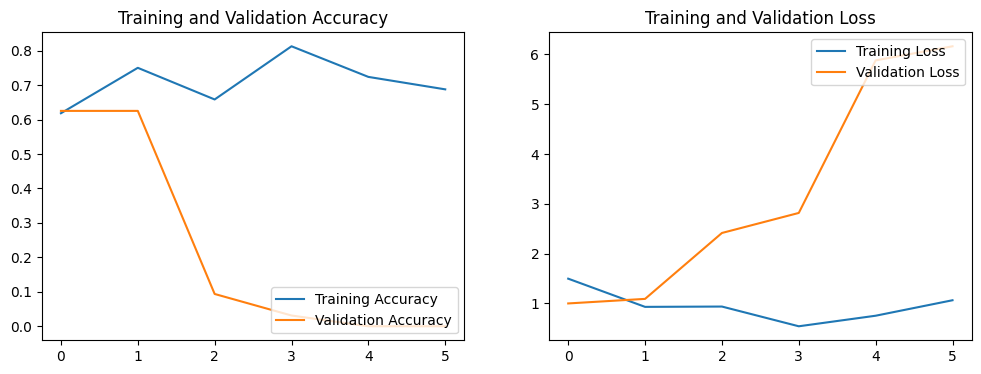

Class Indices: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}
Class indices saved to class_indices.json


In [14]:
# Define image dimensions and batch size
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32
EPOCHS = 25 # Start with fewer epochs, can increase if needed

# Assuming 'categories' is defined in a previous cell (e.g., ['Healthy', 'Powdery', 'Rust'])
NUM_CLASSES = len(categories)

# Define paths (Make sure 'train_path', 'validation_path', 'test_path' are correctly defined in previous cells)
# Example: train_path = './Train', validation_path = './Validation', test_path = './Test'
# These should be the paths containing the subdirectories for each class

# Verify paths exist
if not all(os.path.exists(p) for p in [train_path, validation_path, test_path]):
    print("Error: One or more data paths (train, validation, test) do not exist.")
    print(f"Please ensure these paths are correct:")
    print(f"Train Path: {train_path}")
    print(f"Validation Path: {validation_path}")
    print(f"Test Path: {test_path}")
    # Stop execution or handle the error as needed
    raise FileNotFoundError("Required data directories not found.")

# --- Data Generators ---
# Training data generator with augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test data generator (only rescaling)
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
print(f"Loading training images from: {train_path}")
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical' # for multi-class classification
)

print(f"Loading validation images from: {validation_path}")
validation_generator = test_val_datagen.flow_from_directory(
    validation_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No need to shuffle validation data
)

print(f"Loading test images from: {test_path}")
test_generator = test_val_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No need to shuffle test data
)

# --- Model Architecture ---
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5), # Regularization
    Dense(NUM_CLASSES, activation='softmax') # Output layer for N classes
])

# --- Model Compilation ---
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- Callbacks ---
# Stop training if validation loss doesn't improve for 'patience' epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# --- Model Training ---
print("\nStarting model training...")
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // BATCH_SIZE), # Ensure steps_per_epoch >= 1
    validation_data=validation_generator,
    validation_steps=max(1, validation_generator.samples // BATCH_SIZE), # Ensure validation_steps >= 1
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

# --- Model Evaluation ---
print("\nEvaluating model on test data...")
test_loss, test_acc = model.evaluate(test_generator, steps=max(1, test_generator.samples // BATCH_SIZE)) # Ensure steps >= 1
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# --- Save the Model ---
model_save_path = './models/plant_disease_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# --- Plot Training History ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc)) # Use actual number of epochs run

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Save class indices
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)
# Optionally save class indices to a file (useful for the web app later)

with open('./index/class_indices.json', 'w') as f:
    json.dump(class_indices, f)
print("Class indices saved to class_indices.json within the index folder")


### Data Insights (Summary, Results, Findings)

After working with the dataset, I gained some valuable insights that will guide the next steps in the project. Here's a summary of the findings:

#### 1. **Dataset Summary**:
   - The dataset consists of three categories: **Healthy**, **Powdery**, and **Rust**. These represent different plant leaf diseases, and I plan to add more disease categories in the future to improve the model's versatility.
   - The data is divided into **Train**, **Test**, and **Validation** sets, ensuring that I have separate data for training the model, evaluating its performance, and validating its predictions.

#### 2. **Data Quality**:
   - I checked the dataset for any corrupted images, and luckily, there were no issues found in the `Train`, `Test`, and `Validation` sets. This means the images are all good to go for model training.
   - I also had to adjust for structural differences between the two datasets I used. Dataset 1 had a nested folder structure (e.g., `Train/Train`), while Dataset 2 had a simpler structure. I handled these differences in the code to ensure smooth image loading.

#### 3. **Data Augmentation**:
   - To help the model generalize better, I applied basic **image augmentations** to the training images, such as:
     - **Rotation** (up to 40 degrees)
     - **Horizontal Flip**
   - The idea behind this is to increase the variability in the training data so that the model can learn to recognize plant diseases under different conditions, improving its ability to handle real-world scenarios.

#### 4. **Data Visualization**:
   - I visualized some augmented images to see how the transformations (rotation and flipping) look. These augmentations add variety to the data, which is crucial for training a robust model.
   - This step is useful for understanding how data augmentation affects the images and ensures that the model won't overfit to specific image patterns.

#### 5. **Insights from Augmented Data**:
   - **Increased Variety**: The augmentation allows the model to see different versions of the same images, helping it learn to recognize key features of the disease rather than memorizing the image.
   - **Better Generalization**: By showing the model rotated and flipped versions of the images, I’m helping it generalize better to new, unseen images, which is especially important when working with real-world data.
   - **Balancing Data**: If some categories (like Rust or Powdery) have fewer images, augmentation helps create a more balanced dataset for training, ensuring that the model doesn't favor one category over another.

#### 6. **Potential Challenges**:
   - **Class Imbalance**: If certain categories have fewer images, the model could become biased toward the overrepresented classes. While augmentation helps, I will need to keep an eye on this during training and may consider additional techniques like class weighting.
   - **Over-augmentation**: It’s important not to overdo it with augmentation (e.g., excessive rotations), as it could distort the images too much and make them unrealistic for real-world predictions. I’ll have to monitor this carefully.

### Key Takeaways:
- **Clean Dataset**: The dataset is ready for training, and I’ve ensured that there are no corrupted images.
- **Increased Data Variability**: Augmentation has successfully created more diverse training images, which should help improve the model's performance.
- **Balanced Representation**: I’ve made sure that the data augmentation helps address potential class imbalance, though this will need monitoring during model training.

### Next Steps:
- **Model Training**: I’ll proceed with training a model using the augmented data, and I’ll validate its performance on the test and validation sets to see how well it generalizes.
- **Adding More Diseases**: As part of future improvements, I plan to add other types of plant diseases to the dataset, expanding the model's capabilities to recognize more conditions.
- **Further Monitoring**: I’ll continue to keep an eye on class balance and might adjust the model or augmentations as needed to improve performance.

